In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('housing.csv')
data.dropna(inplace=True)

from sklearn.model_selection import train_test_split
x = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

train_data = x_train.join(y_train)

train_data['total_rooms'] = np.log(train_data['total_rooms'] + 1)
train_data['total_bedrooms'] = np.log(train_data['total_bedrooms'] + 1)
train_data['population'] = np.log(train_data['population'] + 1)
train_data['households'] = np.log(train_data['households'] + 1)

train_data = train_data.join(pd.get_dummies(train_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

train_data['bedroom_ratio'] = train_data['total_bedrooms'] / train_data['total_rooms']
train_data['household_rooms'] = train_data['total_rooms'] / train_data['households']

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train, y_train = train_data.drop(['median_house_value'], axis=1), train_data['median_house_value']
x_train_s = scaler.fit_transform(x_train)

reg = LinearRegression()

reg.fit(x_train_s, y_train)

LinearRegression()

In [3]:
test_data = x_test.join(y_test)

test_data['total_rooms'] = np.log(test_data['total_rooms'] + 1)
test_data['total_bedrooms'] = np.log(test_data['total_bedrooms'] + 1)
test_data['population'] = np.log(test_data['population'] + 1)
test_data['households'] = np.log(test_data['households'] + 1)

test_data = test_data.join(pd.get_dummies(test_data.ocean_proximity)).drop(['ocean_proximity'], axis=1)

test_data['bedroom_ratio'] = test_data['total_bedrooms'] / test_data['total_rooms']
test_data['household_rooms'] = test_data['total_rooms'] / test_data['households']

In [4]:
x_test, y_test = test_data.drop(['median_house_value'], axis=1), test_data['median_house_value']

In [5]:
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)

x_test_s = scaler.transform(x_test)

In [6]:
reg.score(x_test_s, y_test)

0.6693780634089794

In [9]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()

forest.fit(x_train_s, y_train)

RandomForestRegressor()

In [10]:
forest.score(x_test_s,y_test)

0.8084561421061882

In [19]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'min_samples_split': [2, 4],
    'max_depth': [None, 4]
}

grid_search = GridSearchCV(
    forest, param_grid, cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(x_train_s, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 4], 'min_samples_split': [2, 4],
                         'n_estimators': [50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [20]:
best_forest = grid_search.best_estimator_

In [21]:
best_forest.score(x_test_s, y_test)

0.8027790413482687

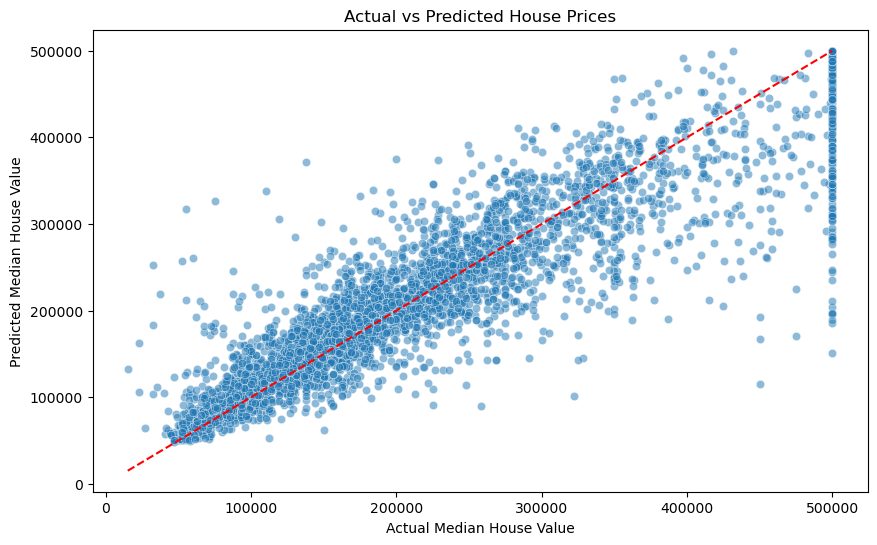

In [22]:
y_pred = best_forest.predict(x_test_s)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Actual vs Predicted House Prices")
plt.show()

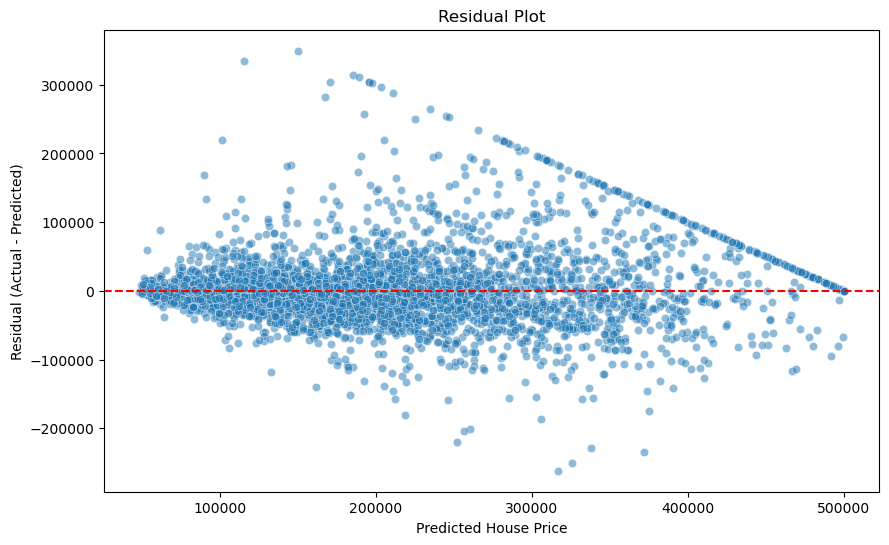

In [23]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted House Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

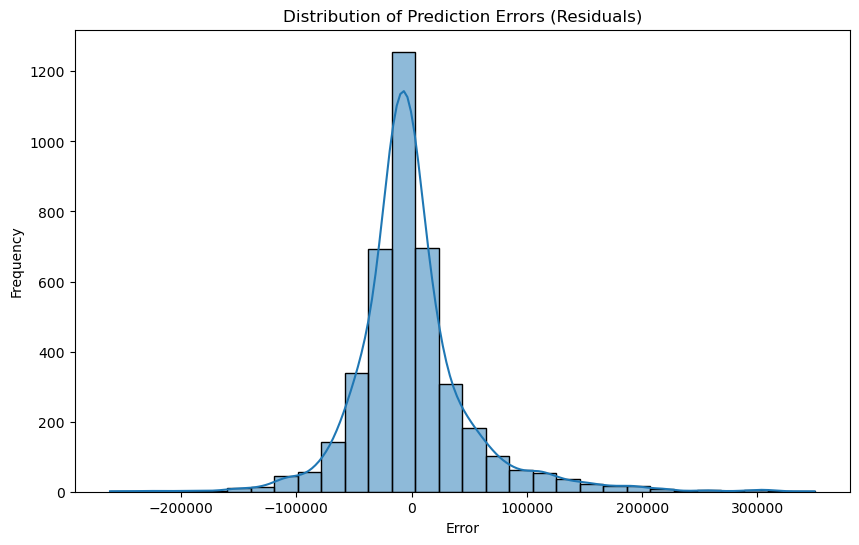

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

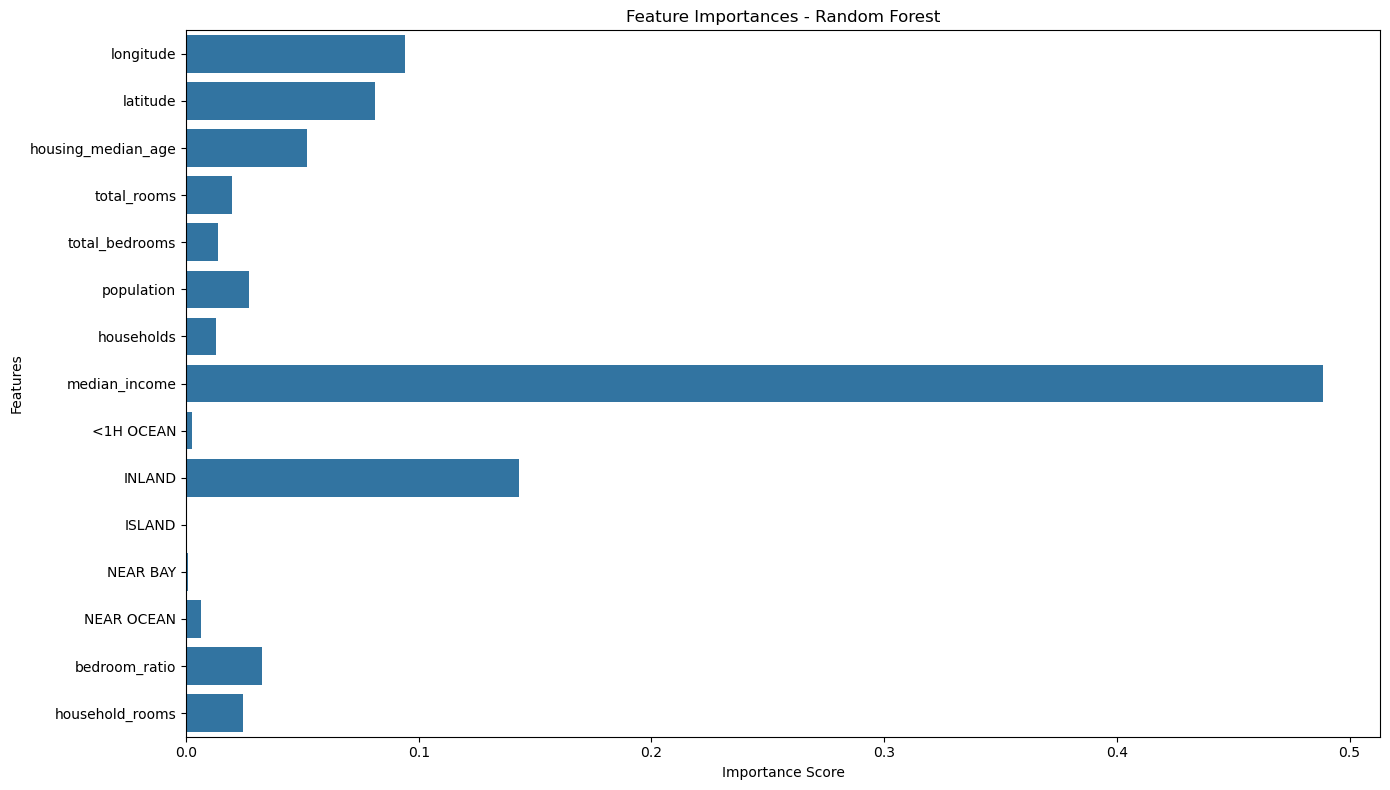

In [25]:
importances = best_forest.feature_importances_
features = x_train.columns

plt.figure(figsize=(14, 8))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()